Updates here: 

https://github.com/olehsamoilenko/habitats

In [ ]:
import ee
import numpy as np
import pandas as pd
import plotly.express as px
import umap.umap_ as umap

In [ ]:
YEAR = 2018
clc = ee.Image(f'COPERNICUS/CORINE/V20/100m/{YEAR}')

ic = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')

In [152]:
landcover_img = clc.select('landcover')  # Level-3 codes (e.g., 111, 112, 211, ...)

print(type(landcover_img))
landcover_img.bandNames().getInfo()

<class 'ee.image.Image'>


['landcover']

In [ ]:
df = pd.read_csv('./data/CLC_Level-1_extra_10_points_per_class__Europe_.csv')

fc_pts = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(lon, lat), {'id': place})
    for idx, (lat,lon,place) in df.iterrows()
])

samples = landcover_img.sampleRegions(
    collection=fc_pts,
    properties=['id'],
    scale=100, 
    geometries=True)

In [ ]:
res = samples.getInfo()['features']

codes = []

for f in res:
    props = f['properties']
    code = int(props['landcover'])
    codes.append(code)
    pid = props['id']
    # print(f"{code} {pid}")

df['corine_code'] = codes
# df.to_csv('./out/europe_corine_codes.csv', index=False, mode='a')

In [ ]:
df = pd.read_csv('./out/europe_corine_codes.csv')

codes = df['corine_code'].tolist()
codes_lvl1 = [str(i)[0] for i in codes]

df['corine_code_lvl1'] = codes_lvl1
df

,lat,lon,place,corine_code,corine_code_lvl1
0,48.856600,2.352200,France Paris city centre (dense urban core),111,1
1,52.521900,13.413200,Germany Berlin Alexanderplatz (highly urban),121,1
2,40.416900,-3.703500,Spain Madrid Puerta del Sol (city core),111,1
3,45.464200,9.190000,Italy Milan Duomo area (urban),111,1
4,52.229700,21.012200,Poland Warsaw Śródmieście (urban centre),111,1
...,...,...,...,...,...
143,44.500000,12.217000,"Adriatic delta with marshes, lagoons and reedb...",211,2
144,43.025278,17.558611,Coastal marshes and lagoons at Neretva mouth (...,212,2
145,40.833333,26.066389,Large deltaic marshes at Greek–Turkish border ...,212,2
146,55.300000,21.000000,Deltaic marshes and reedbeds at lagoon margin ...,324,3


In [79]:
df.groupby(by='corine_code_lvl1').count()

,lat,lon,place,corine_code
corine_code_lvl1,,,,
1,34,34,34,34
2,21,21,21,21
3,48,48,48,48
4,15,15,15,15
5,30,30,30,30


In [85]:
def make_point(lat, lon, cls, cls_lvl1, desc):
    return ee.Feature(ee.Geometry.Point([lon, lat]), { 
        'lat': lat, 'lon': lon, 'class': cls, 'class_lvl1': cls_lvl1, "description": desc
    })

def sample_one(pt, ic):
    img = ic.filterDate(f'2018-01-01', f'2019-01-01').filterBounds(pt).first()
    sampled = img.sample(region=pt, scale=10, numPixels=1, geometries=False).first()
    return sampled

def sample_df(dataframe):
    rows = []
    for idx, (lat, lon,	place, corine_code, corine_code_lvl1) in dataframe.iterrows():
        feature = make_point(lat, lon, corine_code, corine_code_lvl1, place)
        metadata = feature.getInfo()['properties']
        pt = feature.geometry()
        sampled = sample_one(pt, ic)
        try:
            emb = sampled.getInfo()['properties']
            rows.append({**metadata, **emb})
        except:
            print(f"Error {metadata}")
    return rows

rows = sample_df(df)
len(rows)

Error {'class': 243, 'class_lvl1': '2', 'description': 'Arresø (central)', 'lat': 56.019, 'lon': 12.088}
Error {'class': 322, 'class_lvl1': '3', 'description': 'Veluwezoom heath (Posbank)', 'lat': 52.048, 'lon': 6.012}
Error {'class': 324, 'class_lvl1': '3', 'description': 'Deltaic marshes and reedbeds at lagoon margin (Ramsar)', 'lat': 55.3, 'lon': 21}


145

In [ ]:
# embeddings to numpy

def embs_to_numpy(df):
    embs = []
    for i, row in df.iterrows():
        embs.append(np.array(row[5:]))
    embs_np = np.array(embs, dtype='float')
    return embs_np

df_rows = pd.DataFrame(rows)
df_rows.to_csv('out/test_embeddings_corine.csv', index=False)
embs_np = embs_to_numpy(df_rows)
embs_np.shape

(145, 64)

/opt/anaconda3/envs/cv_kau/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



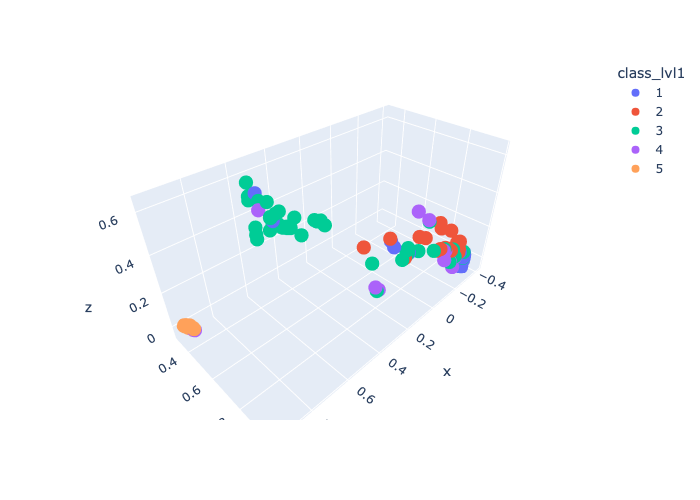

In [ ]:
def reduce_dim(embs, neighbors):
    reducer = umap.UMAP(n_components=3, n_neighbors=neighbors, min_dist=0.0,
                        metric="cosine", random_state=42)
    embs_3d = reducer.fit_transform(embs)

    # norm
    embs_3d = embs_3d / np.linalg.norm(embs_3d, axis=1, keepdims=True)
    return embs_3d

def prep_visual_df(df, embs3d):
    cls      = df['class'].tolist()
    cls_lvl1 = df['class_lvl1'].tolist()

    df_visual = pd.DataFrame(embs3d, columns=['x', 'y', 'z'])
    df_visual['class']      = cls
    df_visual['class_lvl1'] = cls_lvl1
    # df_visual.to_csv('out/test_embeddings_corine_3d.csv')
    return df_visual

def plot(df_visual, renderer="browser"): # renderer="vscode"
    fig = px.scatter_3d(
        df_visual, x="x", y="y", z="z",
        color="class_lvl1",
        hover_data="class",
        width=700, height=700)
    fig.show(renderer) 

embs_3d = reduce_dim(embs_np, neighbors=10)
df_visual = prep_visual_df(df_rows, embs_3d)
plot(df_visual, renderer="png")

/opt/anaconda3/envs/cv_kau/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



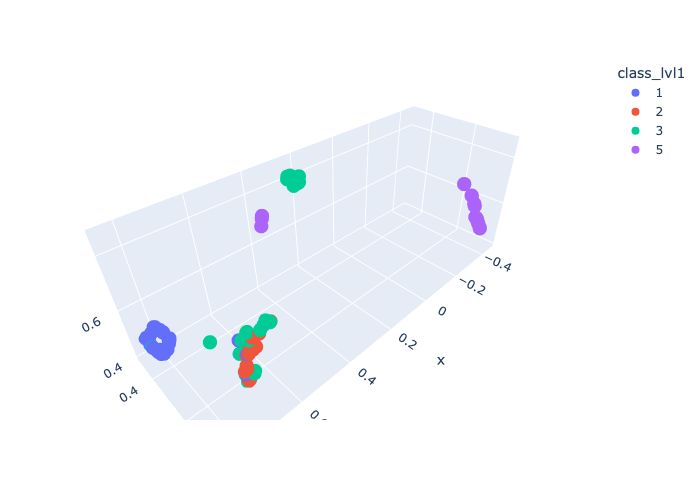

In [149]:
df_no_wet = df_rows[df_rows['class_lvl1'] != '4']

embs = embs_to_numpy(df_no_wet)
embs = reduce_dim(embs, neighbors=4)
df_visual = prep_visual_df(df_no_wet, embs)
plot(df_visual, renderer="png")